<font size=6><b> Setp02. Modeling

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from pandas.plotting import scatter_matrix

# ----------------- 학습 ----------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


# ----------------- 평가 ----------------------
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

from sklearn.preprocessing import Binarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

from sklearn.ensemble     import VotingClassifier

# Data Load

In [28]:
train = pd.read_csv("./datasets/train.csv")
test  = pd.read_csv("./datasets/test.csv")
submit = pd.read_csv("./datasets/sample_submission.csv")

train = train.drop('ID', axis=1)
test  = test.drop('ID', axis=1)

# train['가입일지수'] = train['가입일'].apply(lambda d :  (d / (2213 -d )) * 100 )
train['가입기간년'] = train['가입일'] // 365
train['가입기간월'] = np.floor(train['가입일'] // 12)
# train['가입기간주'] = np.floor(train['가입일'] // 52)
train['가입월']     = np.floor(train['가입일'] / 30) - (  ( np.floor(train['가입일'] / 30) / 12).astype(int) * 12  )  

test['가입기간년']  = test['가입일'] // 365
test['가입기간월']  = np.floor(test['가입일'] // 12)
# test['가입기간주']  = np.floor(test['가입일'] // 52)
test['가입월']      = np.floor(test['가입일'] / 30) - (  ( np.floor(train['가입일'] / 30) / 12).astype(int) * 12  )  

drop_index = train[(train['가입기간년']==5)&(train['전화해지여부']==1)].index.values
train.drop(drop_index, axis=0)

train['총통화시간']   = train['주간통화시간'] + train['저녁통화시간'] + train['밤통화시간']
train['총통화횟수']   = train['주간통화횟수'] + train['저녁통화횟수'] + train['밤통화횟수']
train['총통화요금']   = train['주간통화요금'] + train['저녁통화요금'] + train['밤통화요금']

train['주간시간당요금']   = train['주간통화요금']   / train['주간통화시간']
train['저녁시간당요금']   = train['저녁통화요금']   / train['저녁통화시간']
train['밤시간당요금']   = train['밤통화요금']   / train['밤통화시간']

train.loc[train[train['주간통화시간']==0].index.values, '주간시간당요금'] = 0

# train['시간당요금']   = train['총통화요금']   / train['총통화시간']
# train['횟수당시간']   = train['총통화시간']   / train['총통화횟수']

train['월별총요금'] = train['총통화요금']/train['가입기간월']
train.loc[train[train['가입기간월']==0].index.values, '월별총요금'] = 0
train['월별총횟수'] = train['총통화횟수']/train['가입기간월']
train.loc[train[train['가입기간월']==0].index.values, '월별총횟수'] = 0
train['월별총시간'] = train['총통화시간']/train['가입기간월']
train.loc[train[train['가입기간월']==0].index.values, '월별총시간'] = 0

train['총시간당요금'] = train['총통화요금']/train['총통화시간']
train['총시간당요금'] = pd.cut(train['총시간당요금'], [0, 0.12, 0.3]).astype('category').cat.codes
# train['총시간당요금'] = pd.cut(train['총시간당요금'], [0, 0.11, 0.3]).astype('category').cat.codes

test['총통화시간']   = test['주간통화시간'] + test['저녁통화시간'] + test['밤통화시간']
test['총통화횟수']   = test['주간통화횟수'] + test['저녁통화횟수'] + test['밤통화횟수']
test['총통화요금']   = test['주간통화요금'] + test['저녁통화요금'] + test['밤통화요금']

test['주간시간당요금']   = test['주간통화요금']   / test['주간통화시간']
test['저녁시간당요금']   = test['저녁통화요금']   / test['저녁통화시간']
test['밤시간당요금']   = test['밤통화요금']   / test['밤통화시간']

# test['시간당요금']   = test['총통화요금']   / test['총통화시간']
# test['횟수당시간']   = test['총통화시간']   / test['총통화횟수']

test['월별총요금'] = test['총통화요금']/test['가입기간월']
test.loc[test[test['가입기간월']==0].index.values, '월별총요금'] = 0
test['월별총횟수'] = test['총통화횟수']/test['가입기간월']
test.loc[test[test['가입기간월']==0].index.values, '월별총횟수'] = 0
test['월별총시간'] = test['총통화시간']/test['가입기간월']
test.loc[test[test['가입기간월']==0].index.values, '월별총시간'] = 0

test['총시간당요금'] = test['총통화요금']/test['총통화시간']
test['총시간당요금'] = pd.cut(test['총시간당요금'], [0, 0.12, 0.3]).astype('category').cat.codes
# test['총시간당요금'] = pd.cut(test['총시간당요금'], [0, 0.11, 0.3]).astype('category').cat.codes

# train.loc[5512, '주간시간당요금'] = 0

# 음성사서함 Fillna
fill_idx = train[(train['전화해지여부']==0)&(train['음성사서함이용']>200)].index.values
train.loc[fill_idx, '음성사서함이용']=200

# Over Sampling
* 전화해지 데이터를 미해지 데이터 개수와 동일하게 샘플링할 경우
    * 해지 데이터 내의 Outlier같은 일부 데이터가 확장되어 오히려 성능이 떨어짐.
    * 데이터 수가 너무 많아져서 Overfitting 발생
* RandomOverSampler --> 제출시 가장 점수가 높음
* SMOTE
* ADASYN
* SMOTETomek

In [29]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek

train, _ = RandomOverSampler(sampling_strategy =0.7, random_state=11).fit_resample(train, train['전화해지여부'])
# train, _ = SMOTE(sampling_strategy =0.5, k_neighbors=3, random_state=11).fit_resample(train, train['전화해지여부'])
# train, _ = SMOTETomek(sampling_strategy =0.5, random_state=11).fit_resample(train, train['전화해지여부'])
# train, _ = ADASYN(sampling_strategy =0.5, random_state=11).fit_resample(train, train['전화해지여부'])

train.shape

(45699, 26)

# Cluster 변수

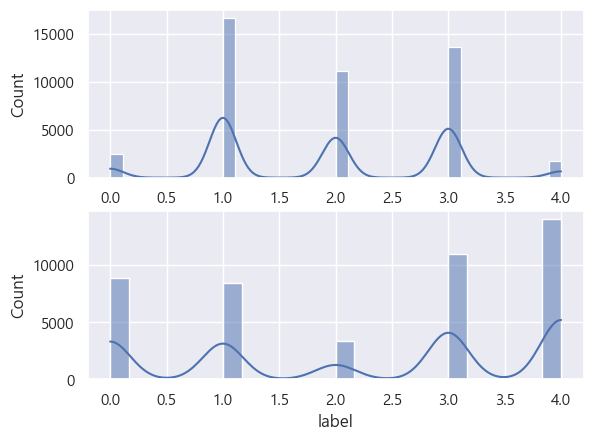

In [5]:
test_temp = test[['주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금']]
train_temp = train[['주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금']]
pca_train0 = train[train['전화해지여부']==0][['주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금']]
pca0 = PCA(n_components=2)
pca0.fit(pca_train0.values)
temp00 = pca0.transform(pca_train0.values)
temp0 = pca0.transform(train_temp)
ttemp0 = pca0.transform(test_temp)

km0 = KMeans(n_clusters=5, random_state=11).fit(temp00)
clu0 = km0.predict(temp0)
cclu0 = km0.predict(ttemp0)

pca_train1 = train[train['전화해지여부']==1][['주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금']]
pca1 = PCA(n_components=2)
pca1.fit(pca_train1.values)
temp11 = pca1.transform(pca_train1.values)
temp1 = pca1.transform(train_temp)
ttemp1 = pca1.transform(test_temp)
km1 = KMeans(n_clusters=5, random_state=11).fit(temp11)
clu1 = km1.predict(temp1)
cclu1 = km1.predict(ttemp1)

train['clu0'] = clu0
train['clu1'] = clu1
test['clu0'] = cclu0
test['clu1'] = cclu1

df0 = pd.DataFrame(clu0, columns=['label'])
df1 = pd.DataFrame(clu1, columns=['label'])

plt.subplot(2,1,1)
sns.histplot(data=df0, x='label', kde=True)
plt.subplot(2,1,2)
sns.histplot(data=df1, x='label', kde=True)
plt.show()

# model selection

In [ ]:
# col_list = ['음성사서함이용', '상담전화건수', '가입기간년', '가입기간월', '가입월', '주간시간당요금', '저녁시간당요금',
#        '밤시간당요금', '월별총요금', '월별총횟수', '월별총시간', 'clu0', 'clu1']

col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

In [ ]:
model_list = [  #("RF"     , RandomForestClassifier(random_state=11)),
                #("KNN", KNeighborsClassifier()),
                ("EXC"     , ExtraTreesClassifier(max_depth=30, random_state=11)),  # ExtraTreesClassifier
                # ("XGB8" , XGBClassifier(n_estimators= 200, max_depth=8, random_state=11)),
                ("XGB201" , XGBClassifier(max_depth=10, n_estimators= 500, random_state=11)),
                # ("VT" , VotingClassifier([ ("EXC"     , ExtraTreesClassifier(max_depth=30, random_state=11)),
                #                           ("XGB201" , XGBClassifier(max_depth=20, n_estimators= 500, random_state=11))])),
             ]

for tpl in model_list :
    model = tpl[1] 

    X_train, X_test, y_train, y_test = train_test_split(trainX, trainy, random_state=11, test_size=0.2, stratify=trainy)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # y_prob = model.predict_proba(X_test)

    # br = Binarizer(threshold=0.25)
    # y_pred = br.fit_transform(y_prob[:, 1].reshape(-1, 1))

    f1_s = f1_score(y_test, y_pred)
    rec_s = recall_score(y_test, y_pred)
    
    print(tpl[0])
    print(f1_s, rec_s)
    print(confusion_matrix(y_test, y_pred))
    print("--"*30)

In [ ]:
# Feature importance 확인
# for i in range(len(col_list)):
#     print(f"{col_list[i]} \t{model.feature_importances_[i]}")
# model.feature_importances_

# Parameter Tuning

In [ ]:
import optuna

col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금', '총시간당요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]
test_ref = pd.read_csv('./ref_file/submit123456.csv')

def objective_XGB(trial, trainX=trainX, trainy=trainy, testX=testX, test_ref=test_ref):
    param = {
        'random_state': 111,
        'n_estimators':  trial.suggest_int('n_estimators', 80, 500), #100,
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        # 'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5), # 'learning_rate': 0.1
        'max_depth': trial.suggest_int('max_depth', 8, 50),
        # 'num_leaves' : trial.suggest_int('num_leaves', 1, 50),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        # 'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = XGBClassifier(**param)  
    
    model.fit(trainX, trainy)
    y_pred = model.predict(testX)
    
    f1_s = f1_score(test_ref['전화해지여부'], y_pred)
    acc_s = accuracy_score(test_ref['전화해지여부'], y_pred)
    
    return acc_s

In [ ]:
study = optuna.create_study(direction='maximize')

study.optimize(objective_XGB, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best param:', study.best_params)
print('Best Score:', study.best_trial.value)

# 최종 학습 및 제출

In [ ]:
# 0.7645479655
col_list = ['음성사서함이용', '상담전화건수', '가입기간년', '가입기간월', '가입월', '주간시간당요금', '저녁시간당요금',
       '밤시간당요금', '월별총요금', '월별총횟수', '월별총시간', 'clu0', 'clu1']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= ExtraTreesClassifier(random_state=11)   # max_depth=8, 

model.fit(trainX, trainy)
y_pred = model.predict(testX)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v3.csv', index=False)

In [ ]:
# 0.800573548
col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= XGBClassifier(max_depth=30, n_estimators= 500, random_state=11)

model.fit(trainX, trainy)
y_pred = model.predict(testX)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v4.csv', index=False)

In [ ]:
# 0.7970649856
col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= XGBClassifier(max_depth=30, n_estimators= 500, random_state=11)

model.fit(trainX, trainy)
y_pred = model.predict(testX)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v6.csv', index=False)

In [ ]:
# 0.8105938651
col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= XGBClassifier(max_depth=10, n_estimators= 500, random_state=11)

model.fit(trainX, trainy)
y_pred = model.predict(testX)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v5.csv', index=False)

In [ ]:
# SMOTETomek 0.503948187
col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= ExtraTreesClassifier(max_depth=10, random_state=11)
model.fit(trainX, trainy)
y_pred = model.predict(testX)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v7.csv', index=False)

In [ ]:
# SMOTETomek, 0.3, 0.806284928 

col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= XGBClassifier(max_depth=10, n_estimators= 500, random_state=11)

model.fit(trainX, trainy)
y_pred = model.predict(testX)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v8.csv', index=False)

In [ ]:
# 0.80707148 -> 0.8258859784283513 (0.5) -> 0.840469874952 (0.7)
# 0.8163424124 (0.3)
# RandomOverSampling, 0.7

col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= XGBClassifier(max_depth=10, n_estimators= 100, learning_rate=0.15,  random_state=11)

model.fit(trainX, trainy)
y_pred = model.predict(testX)

test_ref = pd.read_csv('./ref_file/submit123456.csv')
f1_s = f1_score(test_ref['전화해지여부'], y_pred)
acc_s = accuracy_score(test_ref['전화해지여부'], y_pred)
print(f1_s, acc_s)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v10.csv', index=False)


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

estimators = [
          ('xgb', XGBClassifier(max_depth=10, n_estimators= 100, learning_rate=0.15,  random_state=11)),
          ('et', ExtraTreesClassifier(max_depth=30, max_leaf_nodes=4000, n_estimators= 100, bootstrap=True, random_state=11))
 ]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
 )

# model= ExtraTreesClassifier(max_depth=30, max_leaf_nodes=4000, n_estimators= 100, bootstrap=True, random_state=11)

clf.fit(trainX, trainy)
y_pred = clf.predict(testX)

test_ref = pd.read_csv('./ref_file/submit123456.csv')
f1_s = f1_score(test_ref['전화해지여부'], y_pred)
acc_s = accuracy_score(test_ref['전화해지여부'], y_pred)
print(f1_s, acc_s)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v10.csv', index=False)

In [7]:
col_list = ['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '월별총요금', '총시간당요금']

trainX = train[col_list]
trainy= train['전화해지여부']
testX = test[col_list]

model= XGBClassifier(max_depth=10, n_estimators= 100, learning_rate=0.15,  random_state=11)

model.fit(trainX, trainy)
y_pred = model.predict(testX)

test_ref = pd.read_csv('./ref_file/submit123456.csv')
f1_s = f1_score(test_ref['전화해지여부'], y_pred)
acc_s = accuracy_score(test_ref['전화해지여부'], y_pred)
print(f1_s, acc_s)

# result = pd.read_csv('./datasets/sample_submission.csv')
# result['전화해지여부'] = y_pred
# result.to_csv('./submit_v11.csv', index=False)

0.8773686092241688 0.9734991887506761
